<a href="https://colab.research.google.com/github/avk4714/DL_Projects/blob/master/dropout_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a test implementation of the **Dropout as a Bayesian Approximation methods** by *Gal et al.* from University of Cambridge. The implementation has been made with reference to the paper and video posted by the channel **Viking Penguin** on YouTube.

**1. Define the class for this Dropout method**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt


**a. Create a custom class for Dropout as Bayesian Approximation computation**

In [0]:
class DBA(nn.Module):
  def __init__(self, D_in, D_out, z_prob, lam_mult):
    super(DBA, self).__init__()
    self.z_prob = z_prob
    self.lam_mult = lam_mult
    # Implementing components of the model
    self.mdl_z_prob = Bernoulli(torch.Tensor([self.z_prob]))
    self.mdl_M = torch.ones((D_in, D_out)).normal_(std=0.01)
    self.mdl_m = torch.zeros((D_out))
    self.mdl_W = torch.matmul(torch.diag(torch.ones(D_in).bernoulli_(self.z_prob)),
                              self.mdl_M)
  
  def forward(self, x):
    activation = torch.matmul(x, self.mdl_W) + self.mdl_m
    if self.mdl_m.shape[1] == 1:
      activation = torch.squeeze(activation)
    return activation

  # The regularization term is added to the overall Loss function
  @property
  def regularization(self):
    return lam_mult * (
        self.mdl_z_prob.sample() * torch.sum(torch.square(self.mdl_M)) + 
        torch.sum(torch.square(self.mdl_m))
    )

**b. Building the PyTorch Network Model**

In [0]:
class Net(nn.Module):
  def __init__(self, D_in1, n_hidden, D_out1, z_prob1, lam_mult1):
    super(Net, self).__init__()
    # Layers
    # self.model_L_1 = DBA(D_in1, n_hidden, z_prob1, lam_mult1)
    # self.model_L_2 = DBA(n_hidden, n_hidden, z_prob1, lam_mult1)
    # self.model_L_3 = DBA(n_hidden, D_out1, z_prob1, lam_mult1)
    self.model_L_1 = torch.nn.Linear(D_in1, n_hidden, bias=True)
    self.model_D_1 = torch.nn.Dropout(p=0.5)
    self.model_L_2 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_2 = torch.nn.Dropout(p=0.5)
    self.model_L_3 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_3 = torch.nn.Dropout(p=0.7)
    self.model_L_4 = torch.nn.Linear(n_hidden, D_out1, bias=True)

  def forward(self, x):
    pred_1 = F.relu(self.model_D_1(self.model_L_1(x)))
    pred_2 = F.relu(self.model_D_2(self.model_L_2(pred_1)))
    pred_3 = F.relu(self.model_D_3(self.model_L_3(pred_2)))
    y_pred = self.model_L_4(pred_3)
    return y_pred


**c. Initialization and Training**

1


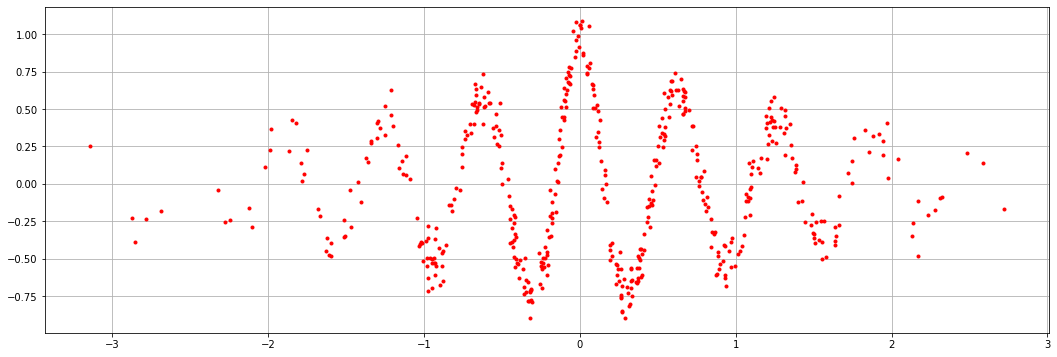

In [71]:
X = Variable(torch.randn(500, 1))
y_t = np.random.normal(np.cos(10. * X) / (np.abs(X) + 1.), 0.1)
# y_tt = Variable(torch.normal(mean=np.cos(10. * X) / (np.abs(X) + 1.),std=0.05))
print(X.shape[1])
if True:
  plt.figure(figsize=(18,6))
  plt.plot(X, y_t, "r.")
  # plt.plot(X, y_tt, "b^")
  plt.grid()
  plt.show()


In [72]:
''' Call the NN and train from here onwards '''
# Sample data.
n_samples = 500
n_hidden = 1000
z_prob = 0.5
lam_mult = 1e-2
d_in = 1
d_out = 1
X = Variable(torch.randn(n_samples, d_in))
y = Variable(torch.normal(mean=np.cos(10. * X) / (np.abs(X) + 1.),std=0.1), requires_grad=False)

X_pred = np.atleast_2d(np.linspace(-3., 3., num=100)).T
X = torch.from_numpy(np.hstack((X, X**2, X**3)))
X_pred = torch.from_numpy(np.hstack((X_pred, X_pred**2, X_pred**3)))


# PyTorch Model.
model = Net(d_in * 3, n_hidden, d_out, z_prob, lam_mult)

# Loss function and Optimizer
criterion1 = torch.nn.MSELoss(size_average=False)
# criterion2 = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Training runs
for t in range(1000):
  y_pred = model(X)

  loss = criterion1(y_pred, y)

  if t % 100 == 99:
    print(t, loss.item())
  
  # zero gradients, perform a backward pass and update the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


99 102.02275085449219
199 68.54936218261719
299 38.903682708740234
399 28.35650062561035
499 23.469661712646484
599 21.13933563232422
699 19.734718322753906
799 19.075864791870117
899 16.03742218017578
999 15.845667839050293


**d. Visualize**

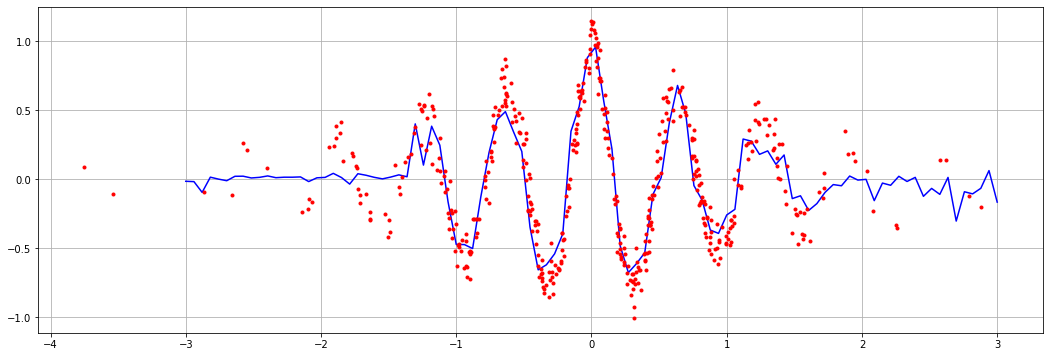

In [73]:
# Y_post = torch.zeros((100,X_pred.shape[0]))
# for tt in range(100):
X_pred2 = np.atleast_2d(np.linspace(-3.,3.,num=100)).T
X_pred2 = torch.from_numpy(np.hstack((X_pred2, X_pred2**2, X_pred2**3)))

if True:
  plt.figure(figsize=(18,6)) 
  # for i in range(n_samples):
  Y_post = model(X_pred2.float())
  plt.plot(X_pred[:,0], Y_post.detach().numpy(),"b-")
  plt.plot(X[:,0], y, "r.")
  plt.grid()
  plt.show()